<a href="https://colab.research.google.com/github/JohnDiognes/analise-perfil-eleitor-vila-velha/blob/main/notebooks/03_analise_geografica_completa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📍 Notebook 03 — Análise Geográfica do Eleitorado de Vila Velha

Este notebook realiza a análise geográfica utilizando:
- Base tratada `base_vila_velha.csv`
- Shapefile dos bairros (`/dados/geodata/bairros_vila_velha.*`)
- Biblioteca `geopandas` para manipulação espacial
- Mapas temáticos sobre sexo, idade, escolaridade e participação por bairro


## 🔧 1. Importação de bibliotecas

In [6]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install contextily
import contextily as ctx
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')

## 📁 2. Caminhos dos arquivos

In [11]:
import subprocess

try:
    # Remove directory if it exists to ensure a clean clone
    subprocess.run(["rm", "-rf", "analise-perfil-eleitor-vila-velha"], check=True)
    # Clone the repository
    subprocess.run(["git", "clone", "https://github.com/JohnDiognes/analise-perfil-eleitor-vila-velha.git"], check=True)
    print("Repositório clonado com sucesso.")
except subprocess.CalledProcessError as e:
    print(f"Erro ao clonar o repositório: {e}")
    if e.stderr:
        print(f"Stderr: {e.stderr.decode()}")
except FileNotFoundError:
    print("Comando 'git' não encontrado. Verifique se o Git está instalado e no PATH.")

Repositório clonado com sucesso.


In [14]:
repo = 'analise-perfil-eleitor-vila-velha'

base_path = f"{repo}/dados/base_vila_velha.csv"
shape_path = f"{repo}/dados/geodata/bairros_vila_velha.shp"

## 📥 3. Carregamento da base de eleitores

In [19]:
df = pd.read_csv(base_path, delimiter=',', encoding='latin1')
print(df.shape)
df.head()

(179494, 31)


,ano,uf,municipio,cod_municipio,zona,secao,cod_genero,genero,cod_estado_civil,estado_civil,...,interprete de libras,bairro,regiao,cod_local_votacao,local_votacao_nome,local_votacao_endereco,quant_eleitores,quant_biometria,quan_deficiencia,quant_nome_social
0,2024,ES,VILA VELHA,57037,32,266,4,FEMININO,3,CASADO,...,NÃO INFORMADO,PAUL,3,1430,UMEF GRACIANO NEVES,"R. COUTO AGUIRRE, 49",1,1,0,0
1,2024,ES,VILA VELHA,57037,32,951,4,FEMININO,3,CASADO,...,NÃO INFORMADO,ITAPOÃ,1,2070,COLÉGIO CEIC,"RUA JAIME DUARTE NASCIMENTO, 617",1,1,0,0
2,2024,ES,VILA VELHA,57037,32,936,4,FEMININO,3,CASADO,...,NÃO INFORMADO,ITAPOÃ,1,2070,COLÉGIO CEIC,"RUA JAIME DUARTE NASCIMENTO, 617",1,1,1,0
3,2024,ES,VILA VELHA,57037,57,155,4,FEMININO,1,SOLTEIRO,...,NÃO INFORMADO,SÃO TORQUATO,4,1201,UMEF JUIZ JAIRO DE MATTOS PEREIRA,"RUA PASTOR AMBROSINO BARBOSA, S/ N",1,1,0,0
4,2024,ES,VILA VELHA,57037,57,48,2,MASCULINO,3,CASADO,...,NÃO INFORMADO,COBILÂNDIA,4,1341,CEEFMTI PASTOR OLIVEIRA DE ARAUJO- ESCOLA VIVA,"AVENIDA OTÁVIO BORIN, S/N",1,1,0,0


## 🗺️ 4. Carregamento do shapefile dos bairros

In [16]:
gdf_bairros = gpd.read_file(shape_path, encoding='latin1')
gdf_bairros = gdf_bairros.to_crs(epsg=3857)
gdf_bairros.head()

,BAIRRO,CODBAIRRO,DocID,OwnerID,CadType,Level,Color,LineWt,Layer,Handle,...,TxtAttach,TxtDir,LnSpace,SpaceFact,DocName,DocPath,DocType,DocVer,XDList,geometry
0,JABURUNA,18,NaN,NaN,None,NaN,NaN,NaN,None,None,...,NaN,NaN,NaN,NaN,None,None,None,None,None,"POLYGON ((-4487089.801 -2312479.012, -4487091...."
1,SANTA MÔNICA,161,NaN,NaN,None,NaN,NaN,NaN,None,None,...,NaN,NaN,NaN,NaN,None,None,None,None,None,"POLYGON ((-4486767.576 -2315817.607, -4486616...."
2,RESIDENCIAL COQUEIRAL,67,NaN,NaN,None,NaN,NaN,NaN,None,None,...,NaN,NaN,NaN,NaN,None,None,None,None,None,"POLYGON ((-4486371.294 -2315509.173, -4486384...."
3,SOTECO,66,NaN,NaN,None,NaN,NaN,NaN,None,None,...,NaN,NaN,NaN,NaN,None,None,None,None,None,"POLYGON ((-4487146.228 -2315338.74, -4487131.4..."
4,COQUEIRAL DE ITAPARICA,12,NaN,NaN,None,NaN,NaN,NaN,None,None,...,NaN,NaN,NaN,NaN,None,None,None,None,None,"POLYGON ((-4487178.411 -2316491.298, -4487104...."


## 🔄 5.1. Pré-processamento da Faixa Etária
Para calcular a idade média, convertemos a coluna `faixa_etaria` em um valor numérico.

In [28]:
def faixa_etaria_to_numeric(faixa):
    if pd.isna(faixa):
        return np.nan
    faixa = str(faixa).replace(' anos', '').replace(' ou mais', '')
    if '-' in faixa:
        low, high = map(int, faixa.split('-'))
        return (low + high) / 2
    elif '80' in faixa: # Handle '80 ou mais'
        return 85 # A reasonable estimate for '80 or more'
    else:
        try:
            return int(faixa)
        except ValueError:
            return np.nan

df['idade_numerica'] = df['faixa_etaria'].apply(faixa_etaria_to_numeric)
df.head()

,ano,uf,municipio,cod_municipio,zona,secao,cod_genero,genero,cod_estado_civil,estado_civil,...,bairro,regiao,cod_local_votacao,local_votacao_nome,local_votacao_endereco,quant_eleitores,quant_biometria,quan_deficiencia,quant_nome_social,idade_numerica
0,2024,ES,VILA VELHA,57037,32,266,4,FEMININO,3,CASADO,...,PAUL,3,1430,UMEF GRACIANO NEVES,"R. COUTO AGUIRRE, 49",1,1,0,0,85.0
1,2024,ES,VILA VELHA,57037,32,951,4,FEMININO,3,CASADO,...,ITAPOÃ,1,2070,COLÉGIO CEIC,"RUA JAIME DUARTE NASCIMENTO, 617",1,1,0,0,NaN
2,2024,ES,VILA VELHA,57037,32,936,4,FEMININO,3,CASADO,...,ITAPOÃ,1,2070,COLÉGIO CEIC,"RUA JAIME DUARTE NASCIMENTO, 617",1,1,1,0,NaN
3,2024,ES,VILA VELHA,57037,57,155,4,FEMININO,1,SOLTEIRO,...,SÃO TORQUATO,4,1201,UMEF JUIZ JAIRO DE MATTOS PEREIRA,"RUA PASTOR AMBROSINO BARBOSA, S/ N",1,1,0,0,NaN
4,2024,ES,VILA VELHA,57037,57,48,2,MASCULINO,3,CASADO,...,COBILÂNDIA,4,1341,CEEFMTI PASTOR OLIVEIRA DE ARAUJO- ESCOLA VIVA,"AVENIDA OTÁVIO BORIN, S/N",1,1,0,0,NaN


## 🔄 5. Agregação de dados por bairro
Agrupamos a base para obter indicadores por bairro.

In [31]:
# Correção do nome do bairro
df['bairro'] = df['bairro'].str.upper().str.strip()
gdf_bairros['bairro'] = gdf_bairros['BAIRRO'].str.upper().str.strip()

# Agregação
agg = df.groupby('bairro').agg(
    total_eleitores=('quant_eleitores', 'sum'),
    perc_mulheres=('genero', lambda x: (x=='FEMININO').mean()*100),
    perc_homens=('genero', lambda x: (x=='MASCULINO').mean()*100),
    media_idade=('idade_numerica', 'mean')
).reset_index()

agg.head()

,bairro,total_eleitores,perc_mulheres,perc_homens,media_idade
0,ALECRIM,2576,54.285714,45.714286,30.420635
1,ALVORADA,7688,54.101058,45.898942,37.995851
2,ARAÇÁS,6409,53.797468,46.202532,33.871595
3,ARGOLAS,2292,54.966393,45.033607,29.949495
4,ARIBIRI,9635,53.936287,46.063713,35.156909


## 🔗 6. União espacial entre base e shapefile

In [32]:
geo = gdf_bairros.merge(agg, left_on='bairro', right_on='bairro', how='left')
geo.head()

,BAIRRO,CODBAIRRO,DocID,OwnerID,CadType,Level,Color,LineWt,Layer,Handle,...,DocPath,DocType,DocVer,XDList,geometry,bairro,total_eleitores,perc_mulheres,perc_homens,media_idade
0,JABURUNA,18,NaN,NaN,None,NaN,NaN,NaN,None,None,...,None,None,None,None,"POLYGON ((-4487089.801 -2312479.012, -4487091....",JABURUNA,2762.0,56.153370,43.846630,36.006667
1,SANTA MÔNICA,161,NaN,NaN,None,NaN,NaN,NaN,None,None,...,None,None,None,None,"POLYGON ((-4486767.576 -2315817.607, -4486616....",SANTA MÔNICA,5548.0,55.865546,44.134454,34.929730
2,RESIDENCIAL COQUEIRAL,67,NaN,NaN,None,NaN,NaN,NaN,None,None,...,None,None,None,None,"POLYGON ((-4486371.294 -2315509.173, -4486384....",RESIDENCIAL COQUEIRAL,NaN,NaN,NaN,NaN
3,SOTECO,66,NaN,NaN,None,NaN,NaN,NaN,None,None,...,None,None,None,None,"POLYGON ((-4487146.228 -2315338.74, -4487131.4...",SOTECO,12114.0,53.991629,45.961866,47.192192
4,COQUEIRAL DE ITAPARICA,12,NaN,NaN,None,NaN,NaN,NaN,None,None,...,None,None,None,None,"POLYGON ((-4487178.411 -2316491.298, -4487104....",COQUEIRAL DE ITAPARICA,30580.0,54.745785,45.254215,33.321162


# 🗺️ 7. Mapas Temáticos

## 🗺️ 7.1 Mapa de Total de Eleitores por Bairro

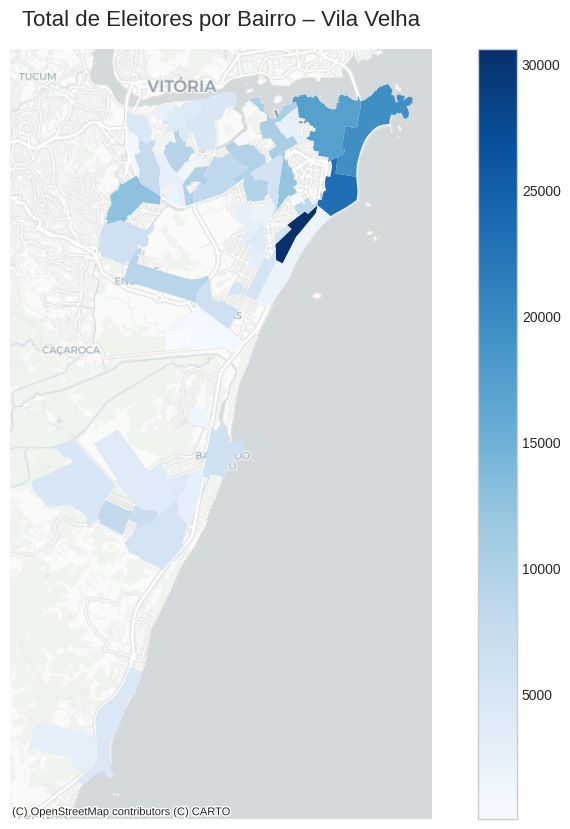

In [35]:
fig, ax = plt.subplots(figsize=(12, 10))
geo.plot(column='total_eleitores', cmap='Blues', legend=True, ax=ax)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title('Total de Eleitores por Bairro – Vila Velha', fontsize=16)
ax.axis('off')
plt.show()

## 🗺️ 7.2 Percentual de Mulheres por Bairro

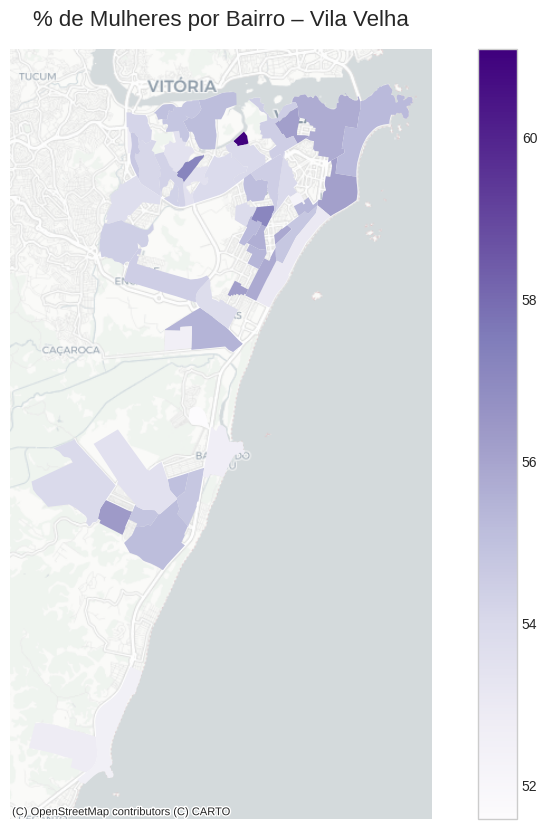

In [36]:
fig, ax = plt.subplots(figsize=(12, 10))
geo.plot(column='perc_mulheres', cmap='Purples', legend=True, ax=ax)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title('% de Mulheres por Bairro – Vila Velha', fontsize=16)
ax.axis('off')
plt.show()

## 🗺️ 7.3 Idade Média do Eleitor por Bairro

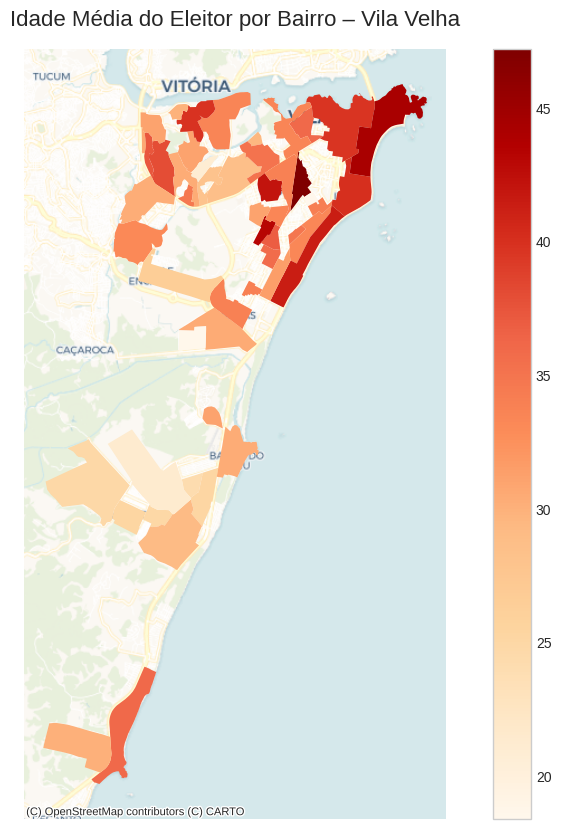

In [39]:
fig, ax = plt.subplots(figsize=(12, 10))
geo.plot(column='media_idade', cmap='OrRd', legend=True, ax=ax)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)
ax.set_title('Idade Média do Eleitor por Bairro – Vila Velha', fontsize=16)
ax.axis('off')
plt.show()

# 📌 8. Destaques e Insights Automáticos

In [40]:
print('Top 5 bairros com mais eleitores:')
display(agg.nlargest(5, 'total_eleitores')[['bairro','total_eleitores']])

print('\nBairros com maior % de mulheres:')
display(agg.nlargest(5, 'perc_mulheres')[['bairro','perc_mulheres']])

print('\nBairros com maior idade média:')
display(agg.nlargest(5, 'media_idade')[['bairro','media_idade']])

Top 5 bairros com mais eleitores:


,bairro,total_eleitores
17,COQUEIRAL DE ITAPARICA,30580
28,ITAPOÃ,23187
39,PRAIA DA COSTA,19409
12,CENTRO,17246
16,COBILÂNDIA,12725



Bairros com maior % de mulheres:


,bairro,perc_mulheres
20,DOM JOÃO BATISTA,61.093248
43,PRIMEIRO DE MAIO,57.204611
11,BRISAMAR,57.142857
29,JABAETÉ,56.367603
22,GUARANHUNS,56.188028



Bairros com maior idade média:


,bairro,media_idade
42,PRAINHA,49.826923
50,SOTECO,47.192192
32,JARDIM MARILÂNDIA,46.515152
39,PRAIA DA COSTA,44.246217
31,JARDIM COLORADO,43.253846


Criar dataframe agregado por região

In [29]:
# Agregar total de eleitores por região
regiao = df.groupby("regiao").size().reset_index(name="total_eleitores")
regiao

,regiao,total_eleitores
0,1,69064
1,2,28416
2,3,28148
3,4,27269
4,5,26597


Criar um GeoDataFrame atribuindo regiões aos bairros

In [33]:
# Garantir que os nomes estão padronizados
df['bairro_up'] = df['bairro'].str.upper().str.strip()

# Agregar eleitores por bairro e região
bairro_regiao = df.groupby(['bairro_up', 'regiao']).size().reset_index(name='total_eleitores')

# Unir com o shapefile
mapa_regiao = gdf_bairros.merge(bairro_regiao, left_on='BAIRRO', right_on='bairro_up', how='left')

mapa_regiao.head()

,BAIRRO,CODBAIRRO,DocID,OwnerID,CadType,Level,Color,LineWt,Layer,Handle,...,DocName,DocPath,DocType,DocVer,XDList,geometry,bairro,bairro_up,regiao,total_eleitores
0,JABURUNA,18,NaN,NaN,None,NaN,NaN,NaN,None,None,...,None,None,None,None,None,"POLYGON ((-4487089.801 -2312479.012, -4487091....",JABURUNA,JABURUNA,1.0,1617.0
1,SANTA MÔNICA,161,NaN,NaN,None,NaN,NaN,NaN,None,None,...,None,None,None,None,None,"POLYGON ((-4486767.576 -2315817.607, -4486616....",SANTA MÔNICA,SANTA MÔNICA,2.0,2975.0
2,RESIDENCIAL COQUEIRAL,67,NaN,NaN,None,NaN,NaN,NaN,None,None,...,None,None,None,None,None,"POLYGON ((-4486371.294 -2315509.173, -4486384....",RESIDENCIAL COQUEIRAL,NaN,NaN,NaN
3,SOTECO,66,NaN,NaN,None,NaN,NaN,NaN,None,None,...,None,None,None,None,None,"POLYGON ((-4487146.228 -2315338.74, -4487131.4...",SOTECO,SOTECO,1.0,6451.0
4,COQUEIRAL DE ITAPARICA,12,NaN,NaN,None,NaN,NaN,NaN,None,None,...,None,None,None,None,None,"POLYGON ((-4487178.411 -2316491.298, -4487104....",COQUEIRAL DE ITAPARICA,COQUEIRAL DE ITAPARICA,1.0,15066.0


Mapa temático (choropleth) por Região usando média dos bairros

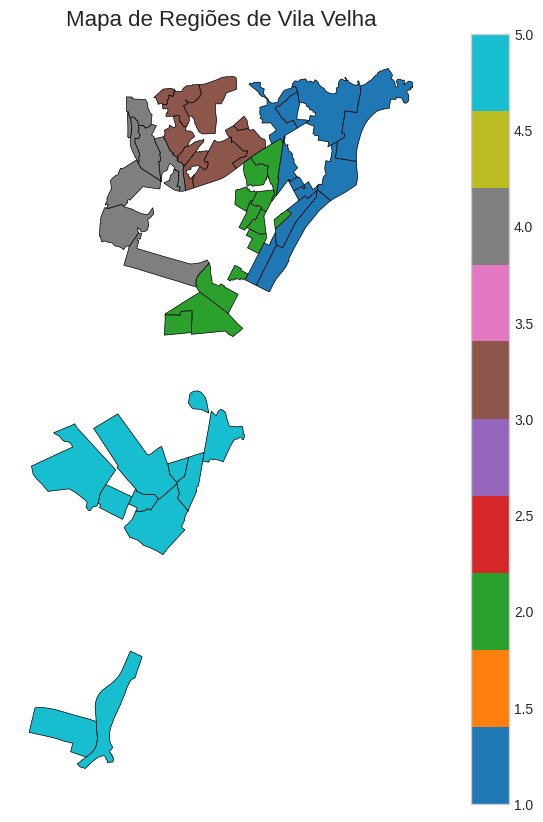

In [50]:
import os

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Filter out NaN values from regiao column before plotting
mapa_regiao_filtered = mapa_regiao.dropna(subset=['regiao'])

mapa_regiao_filtered.plot(
    column="regiao",
    cmap="tab10", # tab10 is a qualitative colormap suitable for categorical data
    legend=True,
    ax=ax,
    edgecolor="black",
    linewidth=0.5
    # Removed legend_kwds to avoid TypeError
)

ax.set_title("Mapa de Regiões de Vila Velha", fontsize=16)
ax.axis("off")

# Create the 'docs' directory if it doesn't exist
os.makedirs('docs', exist_ok=True)
plt.savefig("docs/mapa_regioes.png", dpi=300, bbox_inches="tight")
plt.show()

Mapa com quantidade de eleitores por região

In [51]:
# Total de eleitores por região
eleitores_regiao = df.groupby("regiao").size().reset_index(name="total_eleitores")
eleitores_regiao

,regiao,total_eleitores
0,1,69064
1,2,28416
2,3,28148
3,4,27269
4,5,26597


União com o shapefiles

In [52]:
# Unir com shapefile via bairro → região
mapa_eleitores_regiao = mapa_regiao.dissolve(
    by="regiao",
    aggfunc="sum"
).reset_index()

mapa_eleitores_regiao.head()

,regiao,geometry,BAIRRO,CODBAIRRO,DocID,OwnerID,CadType,Level,Color,LineWt,...,LnSpace,SpaceFact,DocName,DocPath,DocType,DocVer,XDList,bairro,bairro_up,total_eleitores
0,1.0,"POLYGON ((-4487502.483 -2316984.836, -4487385....",JABURUNASOTECOCOQUEIRAL DE ITAPARICABOA VISTA ...,186612141562124177,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,JABURUNASOTECOCOQUEIRAL DE ITAPARICABOA VISTA ...,JABURUNASOTECOCOQUEIRAL DE ITAPARICABOA VISTA ...,64522.0
1,2.0,"MULTIPOLYGON (((-4490961.487 -2319878.442, -44...",SANTA MÔNICADARLY SANTOSPONTAL DAS GARÇASILHA ...,161196190151283133235361848,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,SANTA MÔNICADARLY SANTOSPONTAL DAS GARÇASILHA ...,SANTA MÔNICADARLY SANTOSPONTAL DAS GARÇASILHA ...,25932.0
2,3.0,"POLYGON ((-4489791.749 -2313851.626, -4489779....",VILA GARRIDODOM JOÃO BATISTASANTA RITAPRIMEIRO...,47179225112521194041,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,VILA GARRIDODOM JOÃO BATISTASANTA RITAPRIMEIRO...,VILA GARRIDODOM JOÃO BATISTASANTA RITAPRIMEIRO...,27183.0
3,4.0,"POLYGON ((-4492172.286 -2317083.9, -4492247.50...",PLANALTOCOBI DE BAIXOALVORADARIO MARINHOCOBILÂ...,1715345245254502649,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,PLANALTOCOBI DE BAIXOALVORADARIO MARINHOCOBILÂ...,PLANALTOCOBI DE BAIXOALVORADARIO MARINHOCOBILÂ...,25478.0
4,5.0,"MULTIPOLYGON (((-4495043.735 -2332867.337, -44...",CIDADE DA BARRASANTA PAULA ISÃO CONRADOBARRA D...,1211421385960187181143194139131,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,CIDADE DA BARRASANTA PAULA ISÃO CONRADOBARRA D...,CIDADE DA BARRASANTA PAULA ISÃO CONRADOBARRA D...,26149.0


Gera o mapa

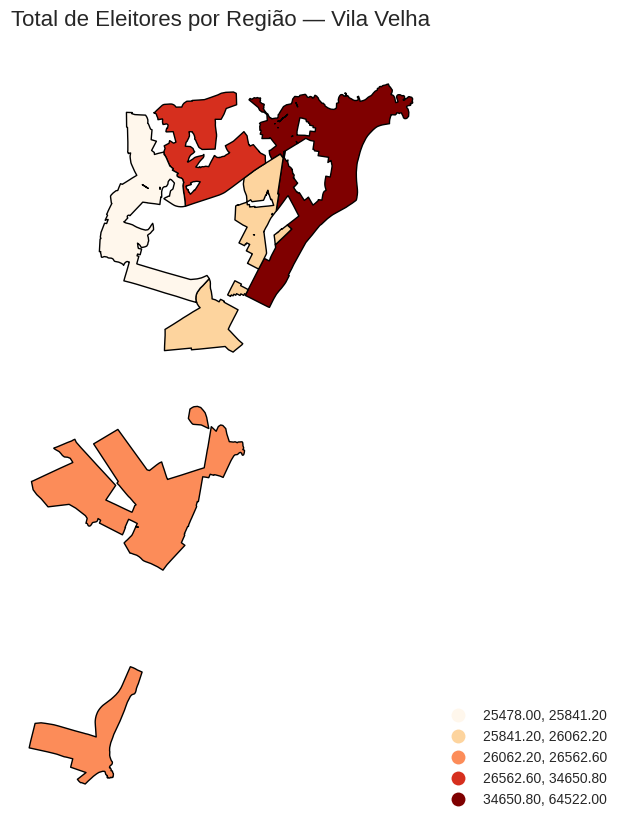

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

mapa_eleitores_regiao.plot(
    column="total_eleitores",
    cmap="OrRd",
    legend=True,
    ax=ax,
    edgecolor="black",
    scheme='quantiles', # Use quantiles scheme
    k=5, # Divide into 5 classes
    legend_kwds={'loc': 'lower left', 'bbox_to_anchor': (1, 0)}
)

ax.set_title("Total de Eleitores por Região — Vila Velha", fontsize=16)
ax.axis("off")

plt.savefig("docs/mapa_eleitores_por_regiao.png", dpi=300, bbox_inches="tight")
plt.show()

Grafico de brras - Eleitores por região

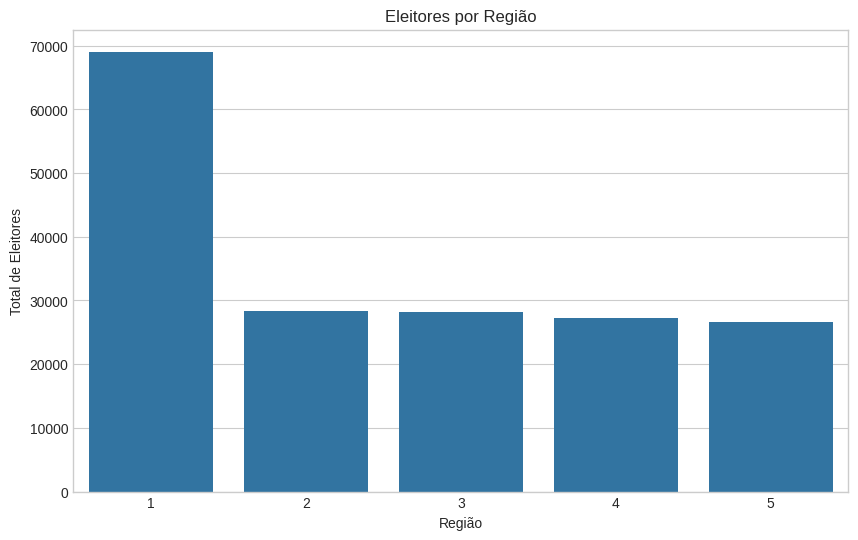

In [54]:
plt.figure(figsize=(10,6))
sns.barplot(data=eleitores_regiao, x="regiao", y="total_eleitores")
plt.title("Eleitores por Região")
plt.xlabel("Região")
plt.ylabel("Total de Eleitores")

plt.savefig("docs/eleitores_por_regiao_barplot.png", dpi=300, bbox_inches="tight")
plt.show()

Tabela de Insitghs por Região

In [58]:
# Criar um dicionário para armazenar os insights por região
insights_regiao = {}

# Lista com todas as regiões
lista_regioes = sorted(df['regiao'].unique())

for reg in lista_regioes:
    df_r = df[df['regiao'] == reg]

    # Total de eleitores da região
    total = df_r.shape[0]

    # Bairros com mais eleitores
    top_bairros = (
        df_r['bairro'].value_counts().head(3).index.tolist()
    )

    # Faixa etária mais comum
    faixa_pred = df_r['faixa_etaria'].mode()[0]

    # Gênero predominante
    genero_pred = df_r['genero'].mode()[0]

    # Escolaridade predominante
    escolaridade_pred = df_r['escolaridade'].mode()[0]

    insights_regiao[reg] = {
        "Total de eleitores": total,
        "Top 3 bairros": top_bairros,
        "Faixa etária mais comum": faixa_pred,
        "Gênero predominante": genero_pred,
        "Escolaridade predominante": escolaridade_pred
    }

# Transformar em DataFrame
df_insights_regiao = pd.DataFrame.from_dict(insights_regiao, orient="index")
df_insights_regiao


,Total de eleitores,Top 3 bairros,Faixa etária mais comum,Gênero predominante,Escolaridade predominante
1,69064,"[COQUEIRAL DE ITAPARICA, ITAPOÃ, CENTRO]",40 a 44 anos,FEMININO,ENSINO MÉDIO COMPLETO
2,28416,"[IBES, ARAÇÁS, SANTA INÊS]",40 a 44 anos,FEMININO,ENSINO MÉDIO COMPLETO
3,28148,"[ARIBIRI, SANTA RITA, VILA GARRIDO]",40 a 44 anos,FEMININO,ENSINO MÉDIO COMPLETO
4,27269,"[COBILÂNDIA, VALE ENCANTADO, ALVORADA]",45 a 49 anos,FEMININO,ENSINO MÉDIO COMPLETO
5,26597,"[TERRA VERMELHA, JABAETÉ, BARRA DO JUCU]",40 a 44 anos,FEMININO,ENSINO MÉDIO COMPLETO


bairros mais influentes

In [59]:
# Agrupar bairro → região → total de eleitores
influ_bairros = df.groupby(["regiao", "bairro"]).size().reset_index(name="total_eleitores")

# Top 5 bairros por região
top_bairros_regiao = (
    influ_bairros
    .sort_values(["regiao", "total_eleitores"], ascending=[True, False])
    .groupby("regiao")
    .head(5)
)

top_bairros_regiao


,regiao,bairro,total_eleitores
3,1,COQUEIRAL DE ITAPARICA,15066
7,1,ITAPOÃ,11256
2,1,CENTRO,8394
9,1,PRAIA DA COSTA,8125
13,1,SOTECO,6451
18,2,IBES,5554
14,2,ARAÇÁS,3318
23,2,SANTA INÊS,3245
24,2,SANTA MÔNICA,2975
17,2,GUARANHUNS,2723


INsitghs por região textual

In [60]:
print("===== INSIGHTS POR REGIÃO =====\n")

for reg in lista_regioes:
    info = insights_regiao[reg]

    print(f"📍 REGIÃO {reg}")
    print(f"• Total de eleitores: {info['Total de eleitores']}")
    print(f"• Bairros mais populosos: {', '.join(info['Top 3 bairros'])}")
    print(f"• Faixa etária predominante: {info['Faixa etária mais comum']}")
    print(f"• Gênero predominante: {info['Gênero predominante']}")
    print(f"• Escolaridade predominante: {info['Escolaridade predominante']}")
    print("-" * 60)


===== INSIGHTS POR REGIÃO =====

📍 REGIÃO 1
• Total de eleitores: 69064
• Bairros mais populosos: COQUEIRAL DE ITAPARICA, ITAPOÃ, CENTRO
• Faixa etária predominante: 40 a 44 anos
• Gênero predominante: FEMININO
• Escolaridade predominante: ENSINO MÉDIO COMPLETO
------------------------------------------------------------
📍 REGIÃO 2
• Total de eleitores: 28416
• Bairros mais populosos: IBES, ARAÇÁS, SANTA INÊS
• Faixa etária predominante: 40 a 44 anos
• Gênero predominante: FEMININO
• Escolaridade predominante: ENSINO MÉDIO COMPLETO
------------------------------------------------------------
📍 REGIÃO 3
• Total de eleitores: 28148
• Bairros mais populosos: ARIBIRI, SANTA RITA, VILA GARRIDO
• Faixa etária predominante: 40 a 44 anos
• Gênero predominante: FEMININO
• Escolaridade predominante: ENSINO MÉDIO COMPLETO
------------------------------------------------------------
📍 REGIÃO 4
• Total de eleitores: 27269
• Bairros mais populosos: COBILÂNDIA, VALE ENCANTADO, ALVORADA
• Faixa etária